<a href="https://colab.research.google.com/github/10944110/AI_FinalReport/blob/main/ai_final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Felicia版本**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy
import time
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil

import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [ ]:
from google.colab import files
files.upload()  #  kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vcat88953","key":"11e88deee27e223abf6fde34d1e94453"}'}

In [ ]:
import json

# 建立 kaggle 資料夾
os.makedirs("/root/.kaggle", exist_ok=True)

# 將剛剛上傳的 kaggle.json 搬到正確位置
!cp kaggle.json /root/.kaggle/kaggle.json

# 設定正確權限
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
#!pip install kagglehub
#!pip install timm # timm 函式庫

import kagglehub
import timm # 匯入 timm

# 下載資料集
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")
print("下載完成，資料集路徑為：", path)

# 確認資料夾結構
base_path = "/kaggle/input/chest-ctscan-images"
print("資料夾內容：", os.listdir(base_path))

下載完成，資料集路徑為： /kaggle/input/chest-ctscan-images
資料夾內容： ['Data']


# 1. 環境與參數設定

In [ ]:
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

# 原始資料集路徑
original_base_dir = '/kaggle/input/chest-ctscan-images/Data'

# 清理後的資料儲存路徑
cleaned_base_dir = '/content/chest-ctscan-images-cleaned'

# 訓練參數
IMG_SIZE = 300
BATCH_SIZE = 16
NUM_EPOCHS_HEAD = 20
NUM_EPOCHS_FULL = 25
LEARNING_RATE_HEAD = 0.002
LEARNING_RATE_FULL = 0.0002
NUM_WORKERS = 2

# 預期類別 (與 test 資料夾內的子資料夾名稱一致)
EXPECTED_CLASSES = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
NUM_CLASSES = len(EXPECTED_CLASSES)

# 設定裝置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")

PyTorch Version: 2.6.0+cu124
Torchvision Version: 0.21.0+cu124


# 2. 整理資料夾結構（統一類別名稱）

In [ ]:
label_mapping = {
    "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib":       "adenocarcinoma",
    "large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa":    "large.cell.carcinoma",
    "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa":"squamous.cell.carcinoma",
    "normal": "normal"
}

print(f"\n--- 從 '{original_base_dir}' 複製並統一到 '{cleaned_base_dir}' ---")

# 創建頂層的 cleaned_base_dir 目錄
os.makedirs(cleaned_base_dir, exist_ok=True)

# 遍歷 'train', 'valid', 'test' 三個分割
for split in ['train', 'valid', 'test']:
    src_dir = os.path.join(original_base_dir, split)
    dst_split_dir = os.path.join(cleaned_base_dir, split) # 目標分割資料夾

    # 創建 cleaned_path 下的 train/valid/test 目錄
    os.makedirs(dst_split_dir, exist_ok=True)

    if not os.path.exists(src_dir):
        print(f"警告：原始資料夾 '{src_dir}' 不存在，跳過此分割。")
        continue

    print(f"處理 '{split}' 分割...")

    # 遍歷原始分割目錄下的所有項目
    for item_name in os.listdir(src_dir):
        original_item_path = os.path.join(src_dir, item_name)

        if os.path.isdir(original_item_path):
            new_label_name = label_mapping.get(item_name, item_name)

            # 目標資料夾路徑 (例如：/kaggle/working/chest-ctscan-images-cleaned/train/adenocarcinoma)
            target_class_dir = os.path.join(dst_split_dir, new_label_name)

            # 創建目標子資料夾
            os.makedirs(target_class_dir, exist_ok=True)

            # 遍歷原始子資料夾中的所有檔案，並複製到新的目標資料夾
            for fname in os.listdir(original_item_path):
                src_file_path = os.path.join(original_item_path, fname)
                dst_file_path = os.path.join(target_class_dir, fname)

                # 只有當目標檔案不存在時才複製
                if not os.path.exists(dst_file_path):
                    try:
                        shutil.copy(src_file_path, dst_file_path)
                    except Exception as e:
                        print(f"複製檔案 '{src_file_path}' 到 '{dst_file_path}' 時發生錯誤: {e}")
        else:
            print(f"'{original_item_path}' 不是資料夾，跳過。")

print("\n資料夾結構整理完成！")

# 更新資料集路徑為清理後的路徑
train_dir = os.path.join(cleaned_base_dir, 'train')
valid_dir = os.path.join(cleaned_base_dir, 'valid')
test_dir = os.path.join(cleaned_base_dir, 'test')


--- 從 '/kaggle/input/chest-ctscan-images/Data' 複製並統一到 '/content/chest-ctscan-images-cleaned' ---
處理 'train' 分割...
處理 'valid' 分割...
處理 'test' 分割...

資料夾結構整理完成！


In [ ]:
train_dir = os.path.join(cleaned_base_dir, 'train')
valid_dir = os.path.join(cleaned_base_dir, 'valid')
test_dir = os.path.join(cleaned_base_dir, 'test')

# 定義要統計的分割類型
splits = {'train': train_dir, 'valid': valid_dir, 'test': test_dir}

for split_name, split_path in splits.items():
    print(f"\n--- {split_name.upper()} 資料集 ---")
    total_images_in_split = 0

    if not os.path.exists(split_path):
        print(f"警告：'{split_path}' 不存在。")
        continue

    # 獲取當前分割下所有類別資料夾的名稱
    class_dirs = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    class_dirs.sort() # 排序以確保輸出順序一致

    for class_name in class_dirs:
        class_path = os.path.join(split_path, class_name)

        # 計算當前類別資料夾中的圖片數量
        images_in_class = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

        print(f"  類別 '{class_name}': {images_in_class} 張圖片")
        total_images_in_split += images_in_class

    print(f"  {split_name.upper()} 資料集總圖片數: {total_images_in_split} 張")



--- TRAIN 資料集 ---
  類別 'adenocarcinoma': 195 張圖片
  類別 'large.cell.carcinoma': 115 張圖片
  類別 'normal': 148 張圖片
  類別 'squamous.cell.carcinoma': 155 張圖片
  TRAIN 資料集總圖片數: 613 張

--- VALID 資料集 ---
  類別 'adenocarcinoma': 23 張圖片
  類別 'large.cell.carcinoma': 21 張圖片
  類別 'normal': 13 張圖片
  類別 'squamous.cell.carcinoma': 15 張圖片
  VALID 資料集總圖片數: 72 張

--- TEST 資料集 ---
  類別 'adenocarcinoma': 120 張圖片
  類別 'large.cell.carcinoma': 51 張圖片
  類別 'normal': 54 張圖片
  類別 'squamous.cell.carcinoma': 90 張圖片
  TEST 資料集總圖片數: 315 張


# 3. 資料載入與預處理

In [ ]:
# 定義影像轉換
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 標準
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMG_SIZE + 32),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE + 32),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 載入資料集
print("\nLoading datasets from cleaned directories...")
try:
    image_datasets = {
        'train': datasets.ImageFolder(train_dir, data_transforms['train']),
        'valid': datasets.ImageFolder(valid_dir, data_transforms['valid']),
        'test': datasets.ImageFolder(test_dir, data_transforms['test'])
    }
except Exception as e:
    print(f"Error loading ImageFolder: {e}")
    print("確保 '{cleaned_base_dir}/train', '{cleaned_base_dir}/valid', '{cleaned_base_dir}/test' 目錄結構正確。")
    exit()

# 檢查類別是否一致
class_names = image_datasets['train'].classes
if sorted(class_names) != sorted(EXPECTED_CLASSES):
    print(f"訓練資料集中的類別名稱 ({class_names}) 與預期類別 ({EXPECTED_CLASSES}) 不匹配。")

print(f"ImageFolder 找到的類別：{class_names}")
print(f"類別數量 (基於 ImageFolder)：{NUM_CLASSES}")


Loading datasets from cleaned directories...
ImageFolder 找到的類別：['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
類別數量 (基於 ImageFolder)：4


# 4. 檢查並處理類別不平衡 (針對訓練集)


Checking class distribution in training set...
Train class counts: Counter({0: 195, 3: 155, 2: 148, 1: 115})


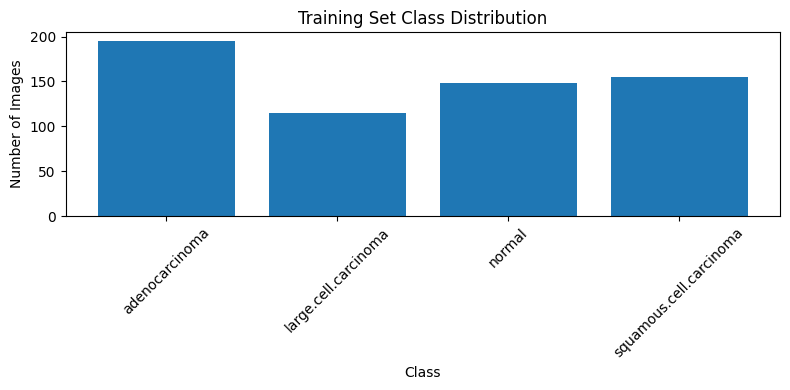

Dataset sizes: {'train': 613, 'valid': 72, 'test': 315}


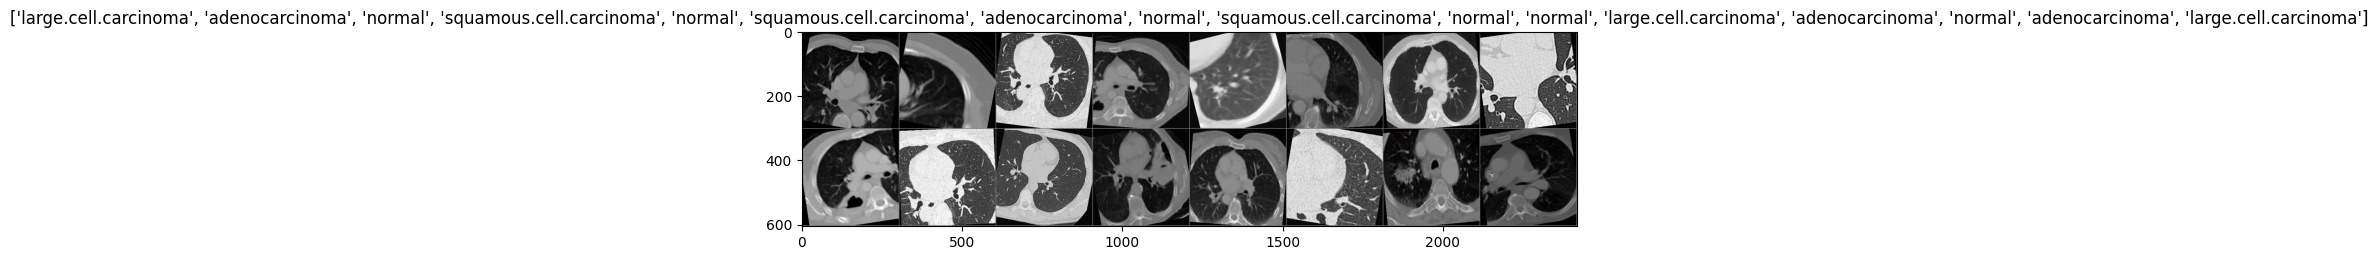

In [ ]:
print("\nChecking class distribution in training set...")
train_class_counts = Counter(image_datasets['train'].targets)
print(f"Train class counts: {train_class_counts}")

# 視覺化類別分佈
plt.figure(figsize=(8, 4))
# 確保類別索引與 class_names 對應
counts = [train_class_counts.get(i, 0) for i in range(len(class_names))]
plt.bar(range(len(class_names)), counts, align='center')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title('Training Set Class Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.tight_layout()
plt.show()

# 計算類別權重用於 WeightedRandomSampler
# 確保權重計算基於所有預期類別的索引
class_weights = [1.0 / train_class_counts.get(i, 1) for i in range(len(class_names))]
sample_weights = [class_weights[label] for label in image_datasets['train'].targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 建立 DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS),
    'valid': DataLoader(image_datasets['valid'], batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS),
    'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
print(f"Dataset sizes: {dataset_sizes}")

# 可視化一個批次的訓練影像 (經過 sampler 和 augmentation)
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

try:
    inputs, classes = next(iter(dataloaders['train']))
    out = torchvision.utils.make_grid(inputs)
    plt.figure(figsize=(10,10))
    imshow(out, title=[class_names[x] for x in classes])
    plt.show()
except RuntimeError as e:
    if "DataLoader worker (pid(s)" in str(e) and NUM_WORKERS > 0:
        print(f"\nCaught RuntimeError related to DataLoader workers. This can sometimes happen in Kaggle notebooks.")
        print("If training fails, try setting NUM_WORKERS = 0 and re-running.")
        print("Continuing for now...\n")
    else:
        raise e

# 5. 模型定義 (使用預訓練 EfficientNet-B3 進行微調)

In [ ]:
# 載入預訓練的 EfficientNet-B3 模型
# pretrained=True 會自動下載 ImageNet 預訓練權重
model_ft = timm.create_model('efficientnet_b3', pretrained=True)

# 凍結所有基礎層的權重
for param in model_ft.parameters():
    param.requires_grad = False

# 替換最後的全連接層 (分類頭)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)
print("\nModel architecture (EfficientNet-B3 with new classifier head):")
print(model_ft) # 查看詳細模型結構

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


Model architecture (EfficientNet-B3 with new classifier head):
EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(4

# 6. 定義損失函數和優化器

In [ ]:
class_weights_loss = [1.0 / train_class_counts.get(i, 1) for i in range(NUM_CLASSES)]
sum_weights = sum(class_weights_loss)
class_weights_loss = [w / sum_weights * NUM_CLASSES for w in class_weights_loss] # 歸一化
class_weights_tensor = torch.tensor(class_weights_loss, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # CrossEntropyLoss 內部已包含 Softmax，並加入類別權重

# --- 訓練函數 ---
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name_prefix="best_model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_val_loss = float('inf') # 追蹤最佳驗證損失
    patience_counter = 0 # 早停耐心計數器
    patience = 7 # 早停耐心值

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 設定模型為訓練模式
            else:
                model.eval()   # 設定模型為評估模式

            running_loss = 0.0
            running_corrects = 0

            # 迭代資料
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # 清除梯度

                # 前向傳播
                # 只在訓練階段追蹤歷史
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 只在訓練階段進行反向傳播 + 優化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else: # phase == 'valid'
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # 更新 ReduceLROnPlateau 學習率排程器
                # 這需要在驗證階段更新，因為它監控驗證損失
                scheduler.step(epoch_loss)

                # 早停邏輯和最佳模型儲存
                if epoch_loss < best_val_loss: # 如果驗證損失有所改善
                    best_val_loss = epoch_loss
                    best_acc = epoch_acc # 同步更新最佳準確率
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0 # 重置耐心計數器

                    output_dir = "/content/best_models"
                    os.makedirs(output_dir, exist_ok=True)
                    torch.save(
                        model.state_dict(),
                        os.path.join(output_dir, f'{model_name_prefix}_epoch{epoch+1}_acc{best_acc:.4f}_loss{best_val_loss:.4f}.pth')
                    )
                    print(f"Saved best model weights with val_acc: {best_acc:.4f} and val_loss: {best_val_loss:.4f}")
                else: # 如果驗證損失沒有改善
                    patience_counter += 1
                    print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()
        # 早停檢查 (在兩個 phase 都完成後)
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss.")
            break # 跳出 epoch 循環

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 載入最佳模型權重
    model.load_state_dict(best_model_wts)
    return model, history

# 7. 第一階段訓練：只訓練分類頭

In [ ]:
print("\n--- Stage 1: Training the classifier head ---")
# 只優化新添加的分類頭的參數
optimizer_head = optim.Adam(model_ft.classifier.parameters(), lr=LEARNING_RATE_HEAD)
# 學習率衰減器：使用 ReduceLROnPlateau
exp_lr_scheduler_head = lr_scheduler.ReduceLROnPlateau(optimizer_head, mode='min', factor=0.1, patience=5, verbose=True)

model_ft, history_head = train_model(model_ft, criterion, optimizer_head, exp_lr_scheduler_head,
                                     num_epochs=NUM_EPOCHS_HEAD, model_name_prefix="best_model_head")



--- Stage 1: Training the classifier head ---
Epoch 1/20
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 1.1929 Acc: 0.4258
Saved best model weights with val_acc: 0.4722 and val_loss: 1.1652
valid Loss: 1.1652 Acc: 0.4722

Epoch 2/20
----------
train Loss: 1.0364 Acc: 0.4829
Saved best model weights with val_acc: 0.5556 and val_loss: 0.9892
valid Loss: 0.9892 Acc: 0.5556

Epoch 3/20
----------
train Loss: 0.9135 Acc: 0.5546
Saved best model weights with val_acc: 0.5833 and val_loss: 0.9370
valid Loss: 0.9370 Acc: 0.5833

Epoch 4/20
----------
train Loss: 0.8841 Acc: 0.5938
Validation loss did not improve. Patience: 1/7
valid Loss: 0.9973 Acc: 0.4861

Epoch 5/20
----------
train Loss: 0.8526 Acc: 0.5971
Validation loss did not improve. Patience: 2/7
valid Loss: 0.9739 Acc: 0.5000

Epoch 6/20
----------
train Loss: 0.8350 Acc: 0.6069
Validation loss did not improve. Patience: 3/7
valid Loss: 0.9551 Acc: 0.5556

Epoch 7/20
----------
train Loss: 0.8188 Acc: 0.6199
Validation loss did not improve. Patience: 4/7
valid Loss: 0.9646 Acc: 0.5417

Epoch 8/20
----------
train Loss: 0.80

# 8. 第二階段訓練：微調整個模型

In [ ]:
print("\n--- Stage 2: Fine-tuning the entire model---")
# 解凍所有層的權重
for param in model_ft.parameters():
    param.requires_grad = True

# 為所有可訓練參數建立一個新的優化器，使用較小的學習率
optimizer_full = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=LEARNING_RATE_FULL)
# 學習率衰減器：使用 ReduceLROnPlateau
exp_lr_scheduler_full = lr_scheduler.ReduceLROnPlateau(optimizer_full, mode='min', factor=0.1, patience=5, verbose=True)

model_ft, history_full = train_model(model_ft, criterion, optimizer_full, exp_lr_scheduler_full,
                                     num_epochs=NUM_EPOCHS_FULL, model_name_prefix="best_model_full")



--- Stage 2: Fine-tuning the entire model---
Epoch 1/25
----------
train Loss: 0.7064 Acc: 0.6868
Saved best model weights with val_acc: 0.6667 and val_loss: 126.9920
valid Loss: 126.9920 Acc: 0.6667

Epoch 2/25
----------
train Loss: 0.5849 Acc: 0.7488
Saved best model weights with val_acc: 0.7361 and val_loss: 0.7367
valid Loss: 0.7367 Acc: 0.7361

Epoch 3/25
----------
train Loss: 0.4375 Acc: 0.7928
Saved best model weights with val_acc: 0.7639 and val_loss: 0.7257
valid Loss: 0.7257 Acc: 0.7639

Epoch 4/25
----------
train Loss: 0.4077 Acc: 0.8418
Saved best model weights with val_acc: 0.8056 and val_loss: 0.6318
valid Loss: 0.6318 Acc: 0.8056

Epoch 5/25
----------
train Loss: 0.3355 Acc: 0.8744
Saved best model weights with val_acc: 0.7917 and val_loss: 0.6020
valid Loss: 0.6020 Acc: 0.7917

Epoch 6/25
----------
train Loss: 0.2863 Acc: 0.8597
Validation loss did not improve. Patience: 1/7
valid Loss: 15.0950 Acc: 0.8056

Epoch 7/25
----------
train Loss: 0.2778 Acc: 0.8842
Vali

# 9. 實驗結果



Evaluating on Test Set...
Shape of all_labels: (315,)
Unique labels in all_labels: [0 1 2 3]
Shape of all_probs: (315, 4)
Dataset size for test set: 315

Classification Report on Test Set:
                         precision    recall  f1-score   support

         adenocarcinoma     0.9106    0.9333    0.9218       120
   large.cell.carcinoma     0.8793    1.0000    0.9358        51
                 normal     1.0000    0.9815    0.9907        54
squamous.cell.carcinoma     0.9630    0.8667    0.9123        90

               accuracy                         0.9333       315
              macro avg     0.9382    0.9454    0.9401       315
           weighted avg     0.9358    0.9333    0.9332       315


Confusion Matrix on Test Set:


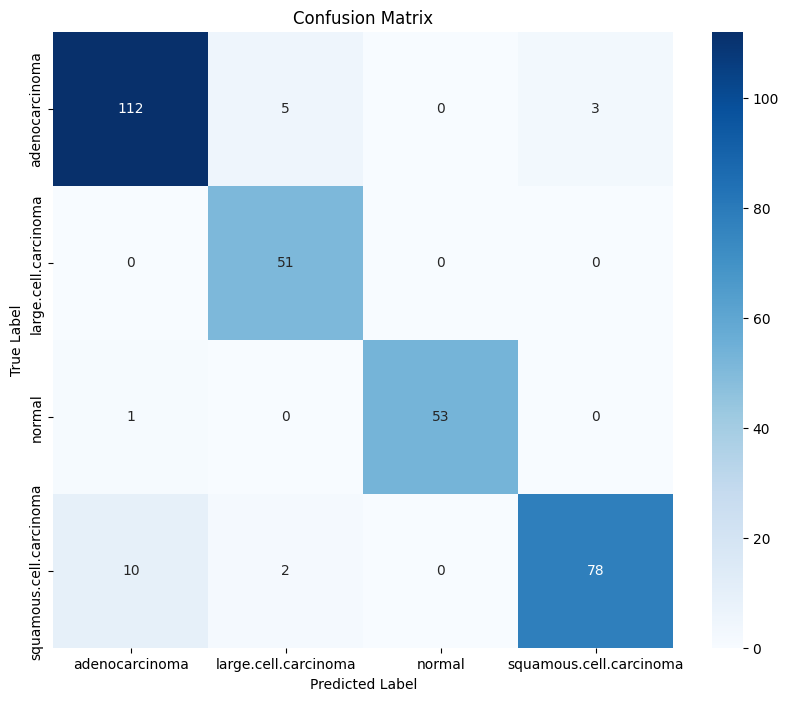

In [ ]:
print("\nEvaluating on Test Set...")
model_ft.eval() # 設定為評估模式
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        # 將 logits 轉換為機率 (Softmax)
        probs = F.softmax(outputs, dim=1)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 將列表轉換為 NumPy 陣列以便於處理
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print(f"Shape of all_labels: {all_labels.shape}")
print(f"Unique labels in all_labels: {np.unique(all_labels) if all_labels.size > 0 else 'No labels collected'}")
print(f"Shape of all_probs: {all_probs.shape}")
print(f"Dataset size for test set: {dataset_sizes['test']}")

print("\nClassification Report on Test Set:")
# 確保 target_names 與 ImageFolder 獲取的 class_names 順序一致
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

print("\nConfusion Matrix on Test Set:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


--- Prediction Probability Distributions ---


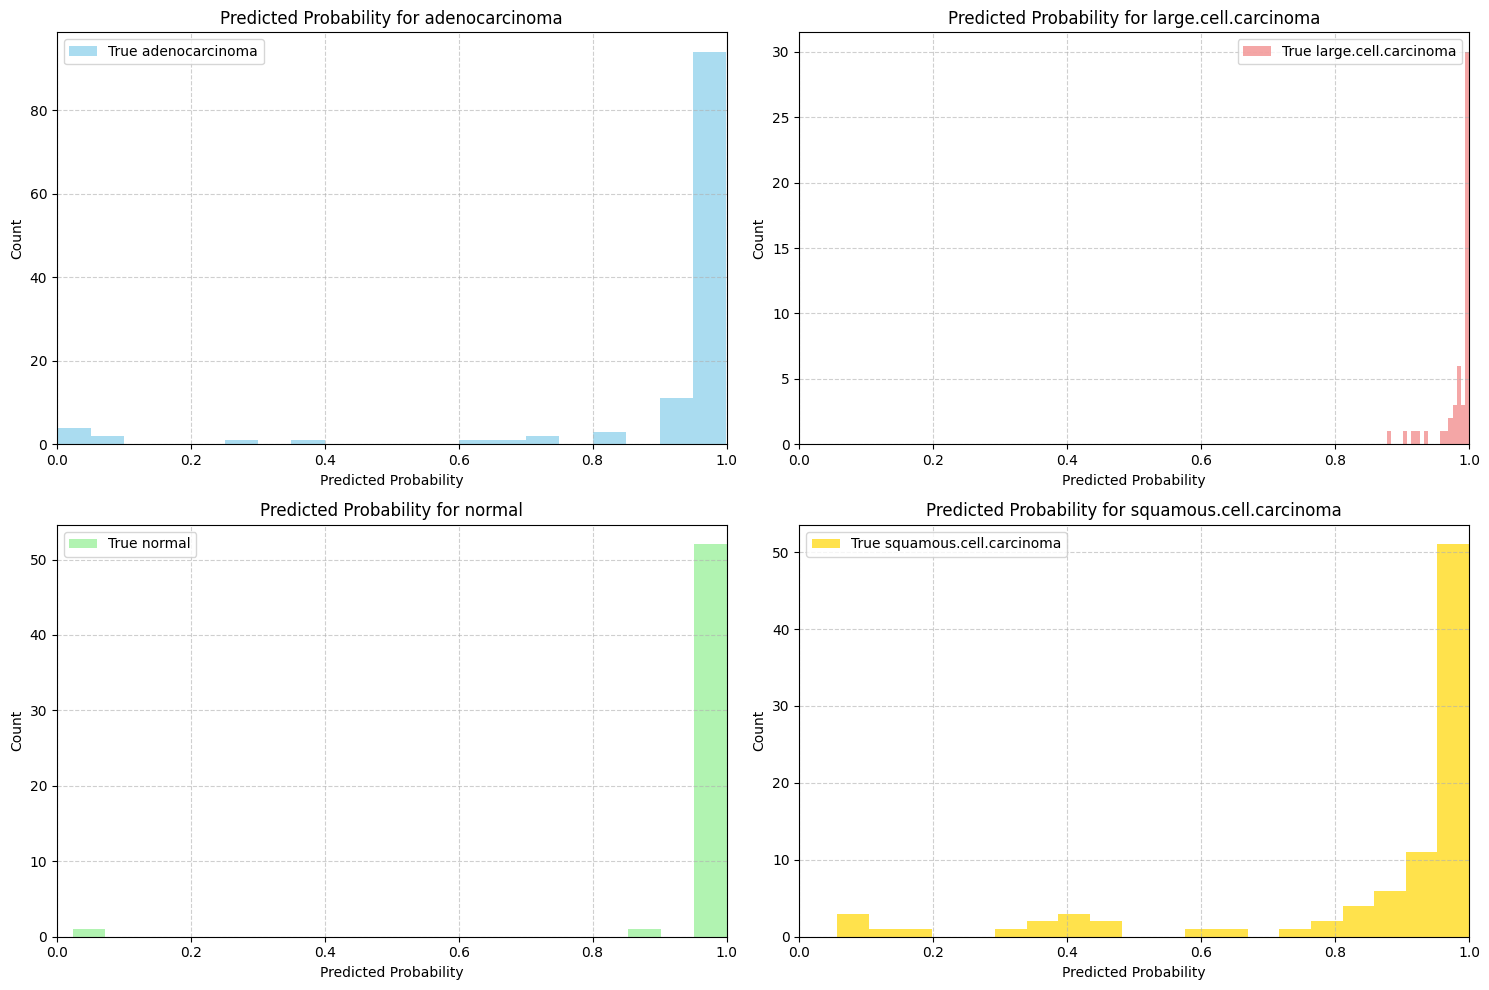

In [ ]:
# --- 繪製 直方圖 (預測機率分佈) ---
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

print("\n--- Prediction Probability Distributions ---")
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    # 獲取該類別的真實標籤為 i 的所有預測機率
    class_true_probs = all_probs[all_labels == i, i]

    # 檢查是否有數據可以繪製直方圖，避免空數據導致錯誤
    if len(class_true_probs) == 0:
        print(f"Warning: No true samples for class '{class_name}' found in test set to plot probability distribution.")

    plt.subplot(2, (NUM_CLASSES + 1) // 2, i + 1) # 自動調整子圖佈局
    plt.hist(class_true_probs, bins=20, alpha=0.7, color=colors[i % len(colors)], label=f'True {class_name}')

    plt.title(f'Predicted Probability for {class_name}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.xlim(0, 1)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


--- PR and ROC Curves---


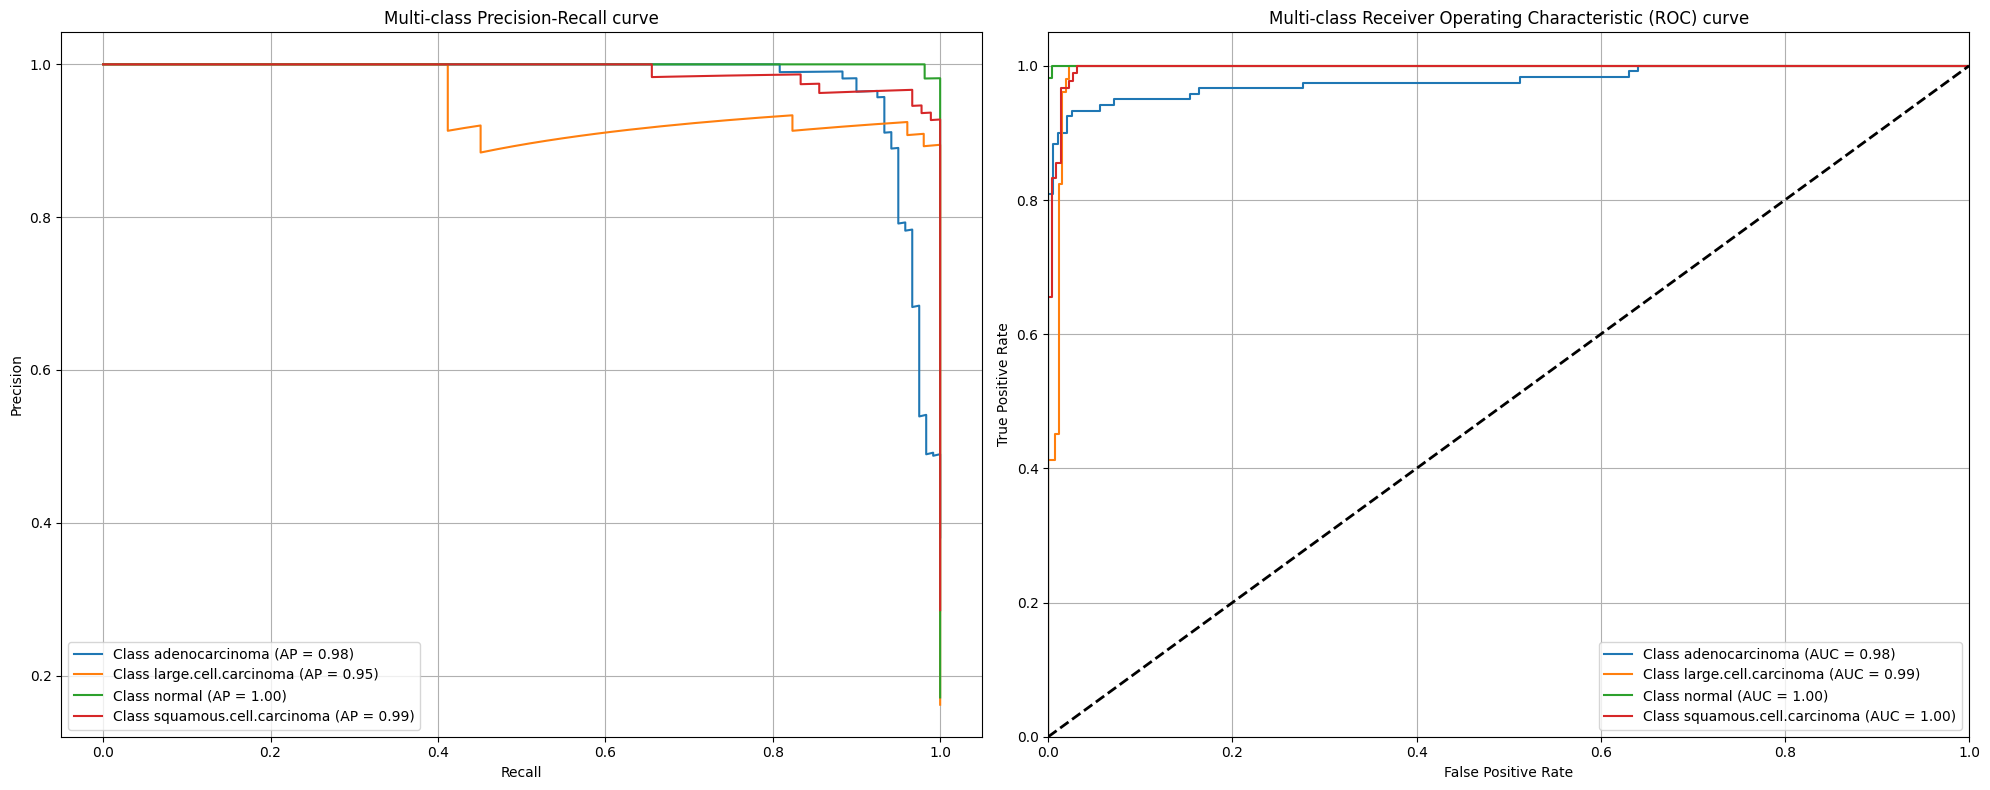

In [ ]:
# --- 繪製 PR 曲線和 ROC 曲線 ---
print("\n--- PR and ROC Curves---")

n_classes = len(class_names)
y_true_one_hot = np.eye(n_classes)[all_labels] # 將 all_labels 轉換為 one-hot 編碼

plt.figure(figsize=(20, 8))

# Precision-Recall Curve
ax1 = plt.subplot(1, 2, 1)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], all_probs[:, i])
    ap = average_precision_score(y_true_one_hot[:, i], all_probs[:, i])
    ax1.plot(recall, precision, label=f'Class {class_names[i]} (AP = {ap:.2f})')

ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Multi-class Precision-Recall curve')
ax1.legend(loc='lower left')
ax1.grid(True)

# Receiver Operating Characteristic (ROC) curve
ax2 = plt.subplot(1, 2, 2)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

ax2.plot([0, 1], [0, 1], 'k--', lw=2) # 隨機猜測線
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Multi-class Receiver Operating Characteristic (ROC) curve')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()


--- Displaying sample images with their predictions ---


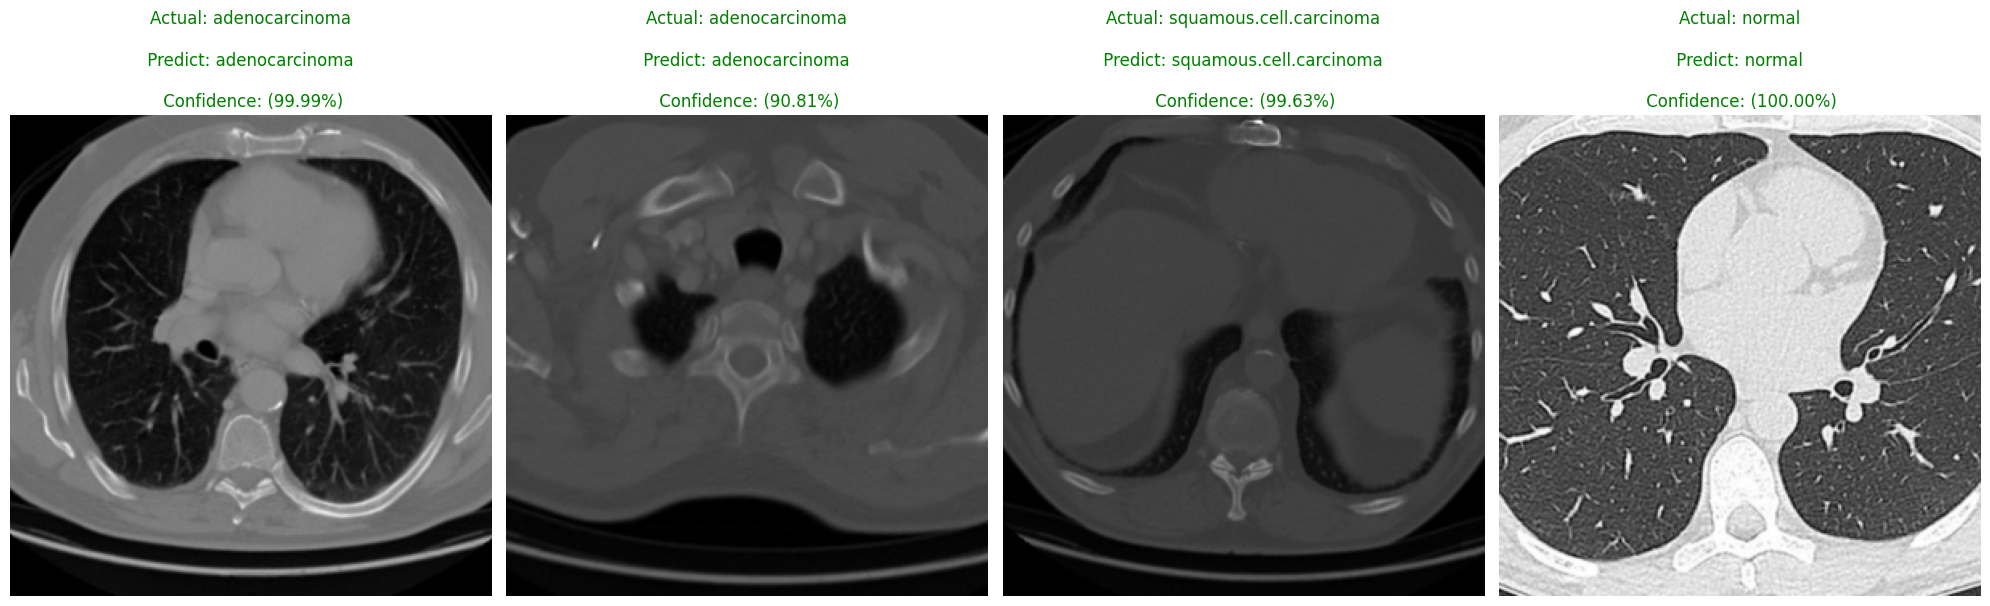

In [ ]:
# --- 顯示多張照片及其預測結果 ---

print("\n--- Displaying sample images with their predictions ---")

# 從測試集中隨機選擇 4 張圖片的索引 確保選擇的索引不重複，且在有效範圍內
num_images_to_display = 4
test_set_size = len(image_datasets['test'])
random_indices = np.random.choice(test_set_size, num_images_to_display, replace=False)

# 將圖片從 Tensor 轉回 PIL 格式以便顯示，並反正規化
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor_np = tensor.numpy().transpose((1, 2, 0)) # 從 (C, H, W) 轉為 (H, W, C)
    tensor_np = std * tensor_np + mean
    tensor_np = np.clip(tensor_np, 0, 1)
    return tensor_np

model_ft.eval()

plt.figure(figsize=(20, 6))

for i, idx in enumerate(random_indices):
    sample_image, true_label_idx = image_datasets['test'][idx]

    with torch.no_grad():
        input_tensor = sample_image.unsqueeze(0).to(device) # 為單張圖片增加一個批次維度
        output = model_ft(input_tensor)
        probabilities = F.softmax(output, dim=1)
        _, predicted_label_idx = torch.max(output, 1)

    # 獲取類別名稱
    true_label_name = class_names[true_label_idx]
    predicted_label_name = class_names[predicted_label_idx.item()]
    confidence = probabilities[0, predicted_label_idx.item()].item() * 100 # 預測的信心度

    # 顯示圖片在子圖中
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(denormalize(sample_image))
    # 判斷預測是否正確，用不同顏色標示
    color = "green" if true_label_name == predicted_label_name else "red"
    plt.title(f"Actual: {true_label_name}\n\n Predict: {predicted_label_name} \n\n Confidence: ({confidence:.2f}%)" , color = color)
    plt.axis('off')

plt.tight_layout()
plt.show()



--- Displaying Sample Incorrectly Classified Images ---


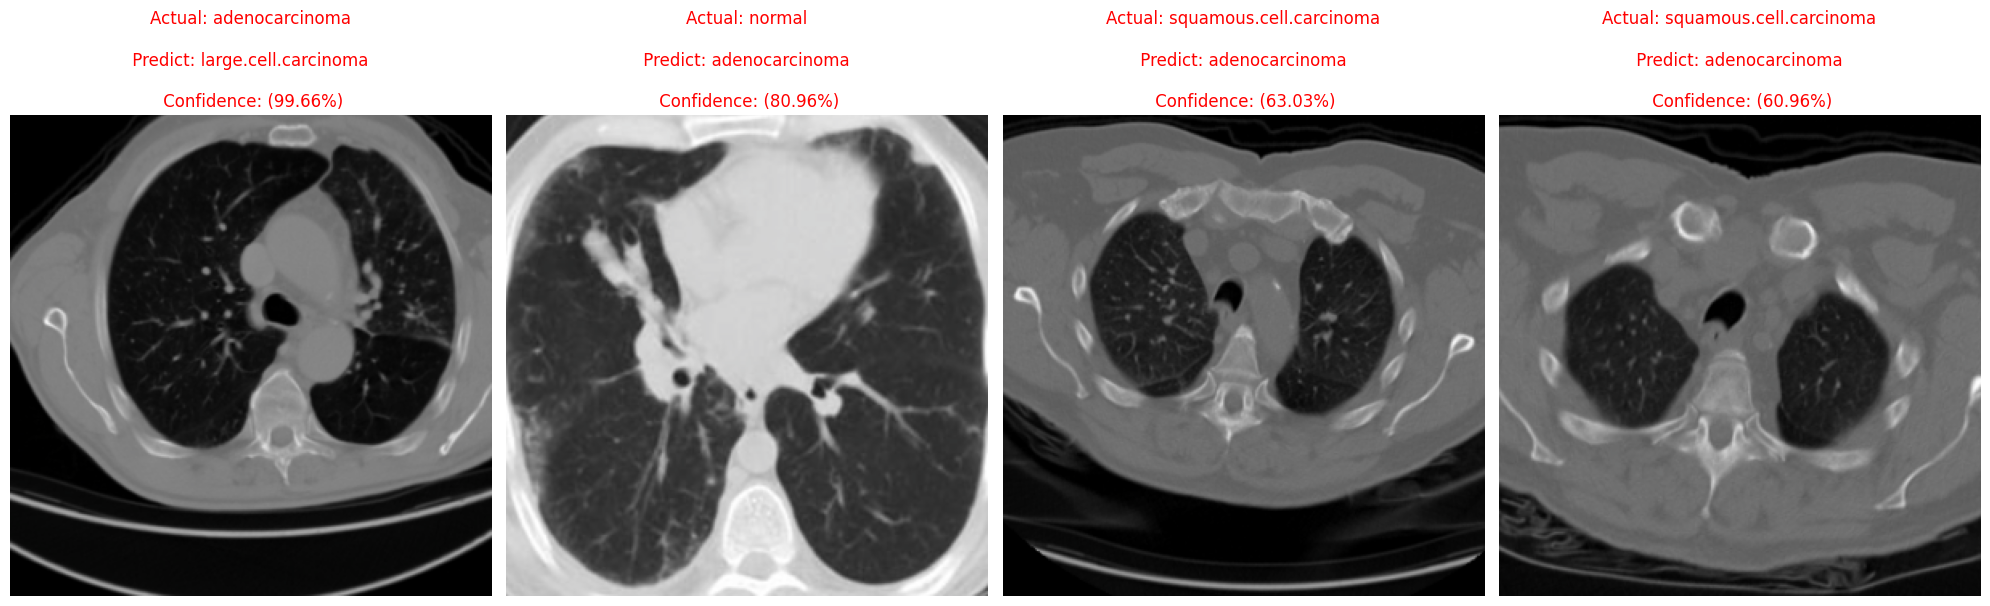

In [ ]:
# --- 顯示錯誤分析的樣本圖像 ---

print("\n--- Displaying Sample Incorrectly Classified Images ---")

# 找出所有預測錯誤的索引
incorrect_indices = np.where(np.array(all_labels) != np.array(all_preds))[0]

if len(incorrect_indices) == 0:
    print("模型沒有任何錯誤預測的圖片！")
else:
    num_error_images_to_display = min(4, len(incorrect_indices)) # 顯示最多4張錯誤圖片，或所有錯誤圖片（如果少於4張）

    # 從錯誤索引中隨機選擇要顯示的圖片
    display_indices = np.random.choice(incorrect_indices, num_error_images_to_display, replace=False)

    # 圖片反正規化函數
    def denormalize(tensor):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        tensor_np = tensor.numpy().transpose((1, 2, 0)) # 從 (C, H, W) 轉為 (H, W, C)
        tensor_np = std * tensor_np + mean
        tensor_np = np.clip(tensor_np, 0, 1)
        return tensor_np

    model_ft.eval() # 設定模型為評估模式

    plt.figure(figsize=(num_error_images_to_display * 5, 6))

    for i, idx_in_test_set in enumerate(display_indices):
        # 獲取原始圖片和標籤（從 image_datasets['test']，通過原始索引）
        sample_image, true_label_idx = image_datasets['test'][idx_in_test_set]

        # 獲取模型預測的標籤和真實標籤（從之前計算的 all_preds 和 all_labels）
        predicted_label_idx = all_preds[idx_in_test_set]
        true_label_name = class_names[true_label_idx]
        predicted_label_name = class_names[predicted_label_idx]

        # 計算錯誤預測的信心度 (模型預測為錯誤類別的機率)
        # all_probs 包含了所有測試樣本的機率
        confidence = all_probs[idx_in_test_set, predicted_label_idx] * 100

        plt.subplot(1, num_error_images_to_display, i + 1)
        plt.imshow(denormalize(sample_image))

        # 標題清晰標註錯誤
        plt.title(f"Actual: {true_label_name}\n\n Predict: {predicted_label_name} \n\n Confidence: ({confidence:.2f}%)" , color="red")
        plt.axis('off')

    plt.tight_layout()
    plt.show()